# Kaggle Challenge Spring 2024 - Neil Kachappilly

## Loading the Data

In [336]:
import pandas as pd

train_df = pd.read_csv('Train_set.csv')

## Data Exploration

In [337]:
train_df.head()

,ID,T0,T1,T2,T3,T4,T5,T6,T7,T8,...,T178,T179,T180,T181,T182,T183,T184,T185,T186,Class
0,0,0.965812,0.792023,0.116809,0.000000,0.162393,0.213675,0.264957,0.247863,0.270655,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1,1.000000,0.597015,0.000000,0.109453,0.094527,0.084577,0.074627,0.094527,0.114428,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2,0.831382,0.714286,0.491803,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,3,1.000000,0.837705,0.236066,0.037705,0.252459,0.329508,0.319672,0.306557,0.304918,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,4,0.868590,0.448718,0.490385,0.477564,0.461538,0.455128,0.416667,0.304487,0.182692,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


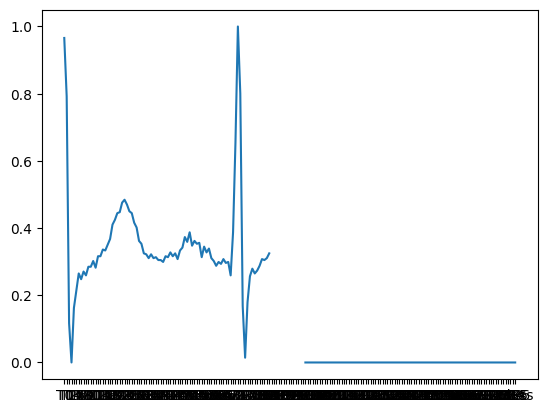

In [338]:
# plot the first time series from train_df
import matplotlib.pyplot as plt

plt.plot(train_df.loc[0].iloc[1:])

In [339]:
# understand label imbalance in the dataset
print(train_df['Class'].value_counts())

Class
0    72471
4     6431
2     5788
1     2223
3      641
Name: count, dtype: int64


In [340]:
# understand how many rows are affected by missing values
print(train_df.isnull().sum())

ID          0
T0        474
T1        919
T2       1327
T3       1711
         ... 
T183     4898
T184     4956
T185     4928
T186     4909
Class       0
Length: 189, dtype: int64


# Data Preprocessing

In [341]:
# Possible idea: delete rows with missing values if they're labeled 0? -- not possible because every one has missing values
mask = (train_df['Class'] == 0) & train_df.isnull().any(axis=1)

num_rows_with_nulls = mask.sum()

print("Number of rows with label 0 and null values:", num_rows_with_nulls)

Number of rows with label 0 and null values: 72471


In [342]:
# # impute missing values in with the median value of the column by label for best replaced data 
# def impute_values(df):
#     grouped = df.groupby('Class')
#     medians = grouped.median()
#     filled_df = df.copy() 
#     for label, group in grouped:
#         mask = (df['Class'] == label)  # Mask to select rows corresponding to the current label
#         for column in df.columns[1:-1]:
#             median_value = medians.loc[label, column]  # Median value for the current label and column
#             filled_df.loc[mask, column] = filled_df.loc[mask, column].fillna(median_value)
#     return filled_df    

# filled_df = impute_values(train_df)
filled_df = train_df.fillna(train_df.median())

In [343]:
# use this test to evaluate the performance of the model before using the actual test data (can train on entire train set for that)
from sklearn.model_selection import train_test_split
# split the data into features and labels
X = filled_df.iloc[:, 1:-1]
y = filled_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Resampling train data so as to avoid data leakage in validation and testing datasets

In [344]:
# print counts in train data
print(y_train.value_counts())

Class
0    57977
4     5145
2     4630
1     1778
3      513
Name: count, dtype: int64


In [345]:
# try oversampling the minority class and undersampling the majority class significantly
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

oversampling_strategy = {1:4500, 3: 4500}
over = SMOTE(sampling_strategy=oversampling_strategy)
undersampling_strategy = {0: 5500}
under = RandomUnderSampler(sampling_strategy=undersampling_strategy)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# apply the pipeline to the data
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

In [346]:
print(pd.Series(y_train_resampled).value_counts()) # check the distribution of the labels after resampling

Class
0    5500
4    5145
2    4630
1    4500
3    4500
Name: count, dtype: int64


In [347]:
from sklearn.metrics import f1_score
def macro_f1(y_pred):
    f1 = f1_score(y_test, y_pred, average='macro')
    return f1

## Trying simple Logistic Regression Model as baseline

In [348]:
# train log reg model on the same data and evaluate
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000)

In [349]:
y_pred = log_reg.predict(X_test)
print("Test macro f1 score using Logistic Regression model: ", macro_f1(y_pred))

Test macro f1 score using Logistic Regression model:  0.48181189809376956


## Neural Network Model

In [350]:
# split the train set into train and validation set for neural networks
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42, stratify=y_train_resampled)

In [351]:
import numpy as np
X_train_reshaped = X_train_nn.values.reshape((X_train_nn.shape[0], X_train_nn.shape[1], 1))
X_val_reshaped = X_val_nn.values.reshape((X_val_nn.shape[0], X_val_nn.shape[1], 1))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

#converting the labels to one-hot encoding so that it matches the shape of neural net output
y_train_onehot = np.eye(5)[y_train_nn]
y_val_onehot = np.eye(5)[y_val_nn]

In [352]:
# implement RNN for this time series multicass classification problem
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow_addons as tfa

# LSTM for multiclass classification
# LSTM_model = Sequential()
# LSTM_model.add(LSTM(64, input_shape=(X_train.shape[1], 1)))
# LSTM_model.add(Dropout(0.2))
# LSTM_model.add(Dense(32, activation='relu'))
# LSTM_model.add(BatchNormalization())
# LSTM_model.add(Dense(5, activation='softmax'))

LSTM_model = Sequential([
    LSTM(64, input_shape=(187, 1), return_sequences=True),
    Dropout(0.5),
    LSTM(64),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])


LSTM_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tfa.metrics.F1Score(num_classes=5,average='macro')])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Define callback for model checkpoint
checkpoint_path = "best_model.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)

LSTM_model.fit(X_train_reshaped, y_train_onehot, epochs=15, batch_size=128, validation_data=(X_val_reshaped, y_val_onehot), callbacks=[early_stopping, checkpoint])

Epoch 1/15
152/152 [==============================] - ETA: 0s - loss: 1.3715 - f1_score: 0.3757
Epoch 1: val_loss improved from inf to 1.22458, saving model to best_model.h5
152/152 [==============================] - 15s 79ms/step - loss: 1.3715 - f1_score: 0.3757 - val_loss: 1.2246 - val_f1_score: 0.4327
Epoch 2/15
152/152 [==============================] - ETA: 0s - loss: 1.1898 - f1_score: 0.4778
Epoch 2: val_loss improved from 1.22458 to 1.12399, saving model to best_model.h5
152/152 [==============================] - 8s 53ms/step - loss: 1.1898 - f1_score: 0.4778 - val_loss: 1.1240 - val_f1_score: 0.5377
Epoch 3/15
152/152 [==============================] - ETA: 0s - loss: 1.1342 - f1_score: 0.5178
Epoch 3: val_loss improved from 1.12399 to 1.07659, saving model to best_model.h5
152/152 [==============================] - 8s 52ms/step - loss: 1.1342 - f1_score: 0.5178 - val_loss: 1.0766 - val_f1_score: 0.5610
Epoch 4/15
152/152 [==============================] - ETA: 0s - loss: 1.1

In [364]:
#get argmax of each softmax output from predict and get predicted class
best_model = tf.keras.models.load_model(checkpoint_path)    
y_pred = best_model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred, axis=1)
print("Test macro f1 score using simple LSTM model: ", macro_f1(y_pred))

548/548 [==============================] - 7s 11ms/step
Test macro f1 score using simple LSTM model:  0.28860757628756656


## Trying ensemble methods considering imbalanced nature of dataset

In [354]:
# trying different sampling method with random forest
# oversampling_strategy = {1:4500, 3: 4500}
# over = SMOTE(sampling_strategy=oversampling_strategy)
undersampling_strategy = {0: 25000}
under = RandomUnderSampler(sampling_strategy=undersampling_strategy)
steps = [('u', under)]
pipeline = Pipeline(steps=steps)

# apply the pipeline to the data
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

In [355]:
# RF without sampling
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
#evaluate
y_pred = rf.predict(X_test)
print("Test macro f1 score using Random Forest model: ", macro_f1(y_pred))

Test macro f1 score using Random Forest model:  0.8815189925506786


In [359]:
#RF with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

rf_pca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pca.fit(X_train_pca, y_train)

RandomForestClassifier(random_state=42)

In [360]:
#evaluate
y_pred = rf_pca.predict(X_test_pca)
print("Test macro f1 score using Random Forest model with PCA: ", macro_f1(y_pred))

Test macro f1 score using Random Forest model with PCA:  0.240917226297685


In [361]:
# try an adaboost model
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(X_train_resampled, y_train_resampled)

AdaBoostClassifier(n_estimators=100, random_state=42)

In [362]:
# evaluate 
y_pred = ada.predict(X_test)
print("Test macro f1 score using AdaBoost model: ", macro_f1(y_pred))

Test macro f1 score using AdaBoost model:  0.4911873097374707


In [363]:
#implement xgboost for this 5 class classification problem on the same data
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=500, learning_rate=0.2, random_state=42, objective='multi:softmax', num_class=5, eval_metric='mlogloss')
xgb.fit(X_train_resampled, y_train_resampled)
# evaluate
y_pred = xgb.predict(X_test)
print("Test macro f1 score using Gradient Boosting model: ", macro_f1(y_pred))

Test macro f1 score using Gradient Boosting model:  0.9054753493268324
